In [42]:
## IMPORTS AND DEFAULT PLOTTING PARAMETERS

import mne ## MNE-Python for analysing data
## below magic provides interactive plots in notebook
%matplotlib widget
from os import chdir
from os.path import join
import matplotlib.pyplot as plt ## for basic plotting
import matplotlib as mpl ## for setting default parameters
import pandas as pd
import numpy as np
import os

# 1. Define path and load in data

In [43]:
# --- Base paths ---
MEG_path = '/work/MEG_data/workshop_data'
subjects_dir = '/work/freesurfer'
behaviour_path = os.path.join(MEG_path, 'behavioural_logs')

# --- List of subjects ---
subjects = ["0163", "0164", "0165", "0166", "0167", "0168", "0169", "0170"]

# dictionary to store the raw files
raws = {}

In [44]:
# --- Loop over subjects ---
for subj in subjects:
    print(f"\n=== Loading subject {subj} ===")

    subj_path = os.path.join(MEG_path, subj)

    # find all subfolders that start with "2025"
    session_dirs = [
        d for d in os.listdir(subj_path)
        if d.startswith("2025") and os.path.isdir(os.path.join(subj_path, d))
    ]

    if not session_dirs:
        print(f"No session folder starting with '2025' found for {subj}")
        continue

    # load the data
    session_dirs.sort()
    session_path = os.path.join(subj_path, session_dirs[-1])

    raw_path = os.path.join(session_path, "workshop_2025_raw.fif")

    if not os.path.exists(raw_path):
        print(f"Raw file not found for {subj}: {raw_path}")
        continue

    raw = mne.io.read_raw_fif(raw_path, preload=True)
    raws[subj] = raw

print("Finished loading all subjects!")



=== Loading subject 0163 ===
Opening raw data file /work/MEG_data/workshop_data/0163/20250922_000000/workshop_2025_raw.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 1956000 ... 3285999 =   1956.000 ...  3285.999 secs
Ready.
Reading 0 ... 1329999  =      0.000 ...  1329.999 secs...

=== Loading subject 0164 ===
Opening raw data file /work/MEG_data/workshop_data/0164/20251003_000000/workshop_2025_raw.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01

# 3. filter the data

In [45]:
for subj, raw in raws.items():
    print(f"\n=== Filtering subject {subj} ===")
    raw.filter(h_freq=40, l_freq=1)


=== Filtering subject 0163 ===
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)


=== Filtering subject 0164 ===
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1

# 4. events


In [46]:
events_by_subj = {}

for subj, raw in raws.items():
    print(f"Finding events for subject {subj} ...")
    events = mne.find_events(raw, shortest_event = 1) 
    events_by_subj[subj] = events

Finding events for subject 0163 ...
Finding events on: STI101
1600 events found on stim channel STI101
Event IDs: [ 1  3  4  6  8 10 12 14]
Finding events for subject 0164 ...
Finding events on: STI101
1601 events found on stim channel STI101
Event IDs: [ 1  3  4  6  8 10 12 14 16]
Finding events for subject 0165 ...
Finding events on: STI101
1600 events found on stim channel STI101
Event IDs: [ 1  3  4  6  8 10 12 14 16]
Finding events for subject 0166 ...
Finding events on: STI101
1600 events found on stim channel STI101
Event IDs: [ 1  3  4  6  8 10 12 14 16]
Finding events for subject 0167 ...
Finding events on: STI101
1600 events found on stim channel STI101
Event IDs: [ 1  3  4  6  8 10 12 14]
Finding events for subject 0168 ...
Finding events on: STI101
1601 events found on stim channel STI101
Event IDs: [ 1  2  3  4  6  8 10 12 14 16]
Finding events for subject 0169 ...
Finding events on: STI101
1600 events found on stim channel STI101
Event IDs: [ 1  3  4  6  8 10 12 14 16]
Fi

# 5. link the events with the behavioural logs

In [47]:
behaviour_by_subj = {}

# --- Loop over subjects ---
for subj in subjects:
    print(f"\n=== Loading behavioural data for subject {subj} ===")

    # find file that starts with the subject ID and 2025
    for file in os.listdir(behaviour_path):
        if file.startswith(f"{subj}_2025") and file.endswith("_experiment_data.csv"):
            behaviour_file = os.path.join(behaviour_path, file)
            break
    else:
        print(f" No behavioural file found for {subj}")
        continue

    behaviour = pd.read_csv(behaviour_file, index_col=False)
    behaviour['PAS_score'] = behaviour['subjective_response'].astype(str) + "00"
    behaviour_by_subj[subj] = behaviour

    print(behaviour.columns)
    print(behaviour)

print("Finished loading behavioural data for all subjects!")


=== Loading behavioural data for subject 0163 ===
Index(['subject', 'trial_number', 'staircase_number', 'fixation_duration_ms',
       'target_duration_ms', 'target_type', 'target_contrast',
       'mask_duration_ms', 'objective_response', 'objective_response_time_ms',
       'subjective_response', 'subjective_response_time_ms', 'PAS_score'],
      dtype='object')
     subject  trial_number  staircase_number  fixation_duration_ms  \
0        163             0                 0            733.333333   
1        163             1                 0            708.333333   
2        163             2                 0            750.000000   
3        163             3                 0            525.000000   
4        163             4                 0            558.333333   
..       ...           ...               ...                   ...   
395      163            35                 9            508.333333   
396      163            36                 9            750.000000   
39

# 6. Only keep stimulus events

In [ ]:
# --- Loop over subjects ---
for subj in subjects:
    print(f"\n=== Applying behavioural PAS labels for subject {subj} ===")

    # skip if we don't have behaviour for this subject
    if subj not in behaviour_by_subj:
        print(f" No behavioural data for {subj}, skipping.")
        continue

    events = events_by_subj[subj]
    behaviour = behaviour_by_subj[subj]

    target_indices = np.isin(events[:, 2], [1, 3]) # i changed this bit
    events = events[target_indices, :] 
    

    if len(events) == 0:
        print(f" No stimulus events found for {subj}, skipping.")
        continue

    n_behav = len(behaviour)
    n_events = len(events)
    if n_behav != n_events:
        print(f" {subj}: mismatch (events={n_events}, behaviour={n_behav}), trimming to shortest.")
        min_len = min(n_behav, n_events)
        events = events[:min_len, :]
        behaviour = behaviour.iloc[:min_len]

    events[:, 2] = behaviour["PAS_score"].astype(int).to_numpy()
    events_by_subj[subj] = events

print("\n Finished applying PAS labels to all subjects!")



=== Applying behavioural PAS labels for subject 0163 ===

=== Applying behavioural PAS labels for subject 0164 ===

=== Applying behavioural PAS labels for subject 0165 ===

=== Applying behavioural PAS labels for subject 0166 ===

=== Applying behavioural PAS labels for subject 0167 ===

=== Applying behavioural PAS labels for subject 0168 ===

=== Applying behavioural PAS labels for subject 0169 ===

=== Applying behavioural PAS labels for subject 0170 ===

✅ Finished applying PAS labels to all subjects!


# 7. Merge pas 4 and 3

In [49]:
# --- Loop over subjects ---
for subj in subjects:
    print(f"\n=== Summarizing and merging PAS scores for subject {subj} ===")

    events = events_by_subj[subj]

    # merge PAS 4 (400) with PAS 3 (300)
    events[events[:, 2] == 400, 2] = 300

    # update dictionary
    events_by_subj[subj] = events

     # show counts before merge
    unique, counts = np.unique(events[:, 2], return_counts=True)
    print(np.asarray((unique, counts)).T)


print("Finished summarizing and merging PAS scores for all subjects!")


=== Summarizing and merging PAS scores for subject 0163 ===
[[100 103]
 [200 241]
 [300  56]]

=== Summarizing and merging PAS scores for subject 0164 ===
[[100 100]
 [200 202]
 [300  98]]

=== Summarizing and merging PAS scores for subject 0165 ===
[[100  73]
 [200 137]
 [300 190]]

=== Summarizing and merging PAS scores for subject 0166 ===
[[100  53]
 [200 274]
 [300  73]]

=== Summarizing and merging PAS scores for subject 0167 ===
[[100 149]
 [200 174]
 [300  77]]

=== Summarizing and merging PAS scores for subject 0168 ===
[[100 114]
 [200 137]
 [300 149]]

=== Summarizing and merging PAS scores for subject 0169 ===
[[100  62]
 [200 139]
 [300 199]]

=== Summarizing and merging PAS scores for subject 0170 ===
[[100  94]
 [200 181]
 [300 125]]
Finished summarizing and merging PAS scores for all subjects!


# Only keep Pas 1 and 3:

In [68]:
# --- Create filtered event sets: PAS 100 vs 200 ---
events_1vs2_by_subj = {}

for subj in subjects:
    print(f"\n=== Filtering PAS 100 vs 200 for subject {subj} ===")

    if subj not in events_by_subj:
        print(f"No events found for {subj}, skipping.")
        continue

    events = events_by_subj[subj]

    # keep only PAS 100 and 200
    mask = np.isin(events[:, 2], [100, 200])
    events_1vs2 = events[mask]

    if len(events_1vs2) == 0:
        print(f"No PAS 100/200 trials for {subj}, skipping.")
        continue

    events_1vs2_by_subj[subj] = events_1vs2
    print(f" {subj}: kept {len(events_1vs2)} trials (PAS 100/200 only)")

print("\n Finished filtering PAS 100 vs 200 for all subjects!")



=== Filtering PAS 100 vs 200 for subject 0163 ===
 0163: kept 344 trials (PAS 100/200 only)

=== Filtering PAS 100 vs 200 for subject 0164 ===
 0164: kept 302 trials (PAS 100/200 only)

=== Filtering PAS 100 vs 200 for subject 0165 ===
 0165: kept 210 trials (PAS 100/200 only)

=== Filtering PAS 100 vs 200 for subject 0166 ===
 0166: kept 327 trials (PAS 100/200 only)

=== Filtering PAS 100 vs 200 for subject 0167 ===
 0167: kept 323 trials (PAS 100/200 only)

=== Filtering PAS 100 vs 200 for subject 0168 ===
 0168: kept 251 trials (PAS 100/200 only)

=== Filtering PAS 100 vs 200 for subject 0169 ===
 0169: kept 201 trials (PAS 100/200 only)

=== Filtering PAS 100 vs 200 for subject 0170 ===
 0170: kept 275 trials (PAS 100/200 only)

 Finished filtering PAS 100 vs 200 for all subjects!


# 8. Creating the epochs

In [69]:
# --- Loop over subjects --- (skipping 0164)
for subj in subjects:

    print(f"\n=== Creating epochs for subject {subj} ===")

    raw = raws[subj]
    events = events_1vs2_by_subj[subj]

    # create dict with event ID mapped to desired labels
    event_ids = {"PAS1": 100,
                 "PAS2": 200}

    # define input to epoch function
    tmin = -0.200
    tmax = 0.550
    baseline = (-0.200, 0)
    reject = {'eog': 250e-6}

    # epoch data with EOG rejection
    epochs = mne.Epochs(raw,
                        events=events,
                        event_id=event_ids,
                        tmin=tmin,
                        tmax=tmax,
                        baseline=baseline,
                        preload=True,
                        reject=reject,
                        on_missing='ignore')

    # store both in dictionaries if you want to keep them
    if 'epochs_by_subj' not in locals():
        epochs_by_subj = {}

    epochs_by_subj[subj] = epochs

print("\n Finished creating epochs for all subjects (skipped 0164).")




=== Creating epochs for subject 0163 ===
Not setting metadata
344 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 344 events and 751 original time points ...
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
4 bad epochs dropped

=== Creating epochs for subject 0164 ===
Not setting metadata
302 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 302 events and 751 original time points ...
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on

# Force Balance

In [ ]:
# --- Force-balance PAS1 vs PAS2 per subject ---

epochs_balanced_by_subj = {}

for subj, ep in epochs_by_subj.items():
    print(f"\n=== Balancing epochs for subject {subj} ===")

    # get condition names, e.g. ["PAS1", "PAS2"]
    conds = list(ep.event_id.keys())
    if len(conds) != 2:
        print(f"{subj}: Expected 2 conditions, found {conds}. Skipping.")
        continue

    # split epochs into the two PAS conditions
    ep_list = [ep[conds[0]], ep[conds[1]]]

    # balance the number of trials
    mne.epochs.equalize_epoch_counts(ep_list)

    # merge back together
    ep_balanced = mne.concatenate_epochs(ep_list)
    epochs_balanced_by_subj[subj] = ep_balanced

    print(f" {subj}: kept {len(ep_list[0])} epochs per condition (total {len(ep_balanced)})")

print("\n Finished balancing PAS1 vs PAS2 for all subjects!")



=== Balancing epochs for subject 0163 ===
Dropped 0 epochs: 
Dropped 136 epochs: 0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 50, 66, 67, 68, 69, 77, 78, 79, 80, 81, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 117, 118, 119, 120, 121, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 154, 155, 156, 157, 158, 159, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 187, 188, 189, 190, 191, 192, 193, 212, 213, 214, 215, 216, 217, 218, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237
Not setting metadata
204 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
 0163: kept 102 epochs per condition (total 204)

=== Balancing epochs for subject 0164 ===
Dropped 0 epochs: 
Dropped 104 epochs: 0, 1, 5, 6, 7, 8, 10, 15

# Source space

1. create forward model

In [71]:
import os
import glob
from os.path import join
import mne

# --- CONFIG ---
MEG_ROOT = "/work/MEG_data/workshop_data"
FREESURFER_DIR = "/work/freesurfer"
fwd_by_subj = {}

# --- LOOP OVER SUBJECTS ---
for subj in subjects:
    print(f"\n=== Building forward model for subject {subj} ===")

    # 1) Info (from your epochs or evoked)
    info = epochs_balanced_by_subj[subj].info

    # 2) Recursively find the .trans file that starts with "2025"
    search_pattern = join(MEG_ROOT, subj, "2025*", "*-trans.fif")
    trans_candidates = glob.glob(search_pattern, recursive=True)
    trans_file = trans_candidates[0] if trans_candidates else None

    if trans_file is None:
        print(f"  No trans file found for {subj} (looked for {search_pattern}) — skipping.")
        continue

    print(f"  → Using trans file: {trans_file}")

    # 3) Construct src and bem paths
    src = join(FREESURFER_DIR, subj, "bem", f"{subj}-oct-6-src.fif")
    bem = join(FREESURFER_DIR, subj, "bem", f"{subj}-5120-bem-sol.fif")

    # 4) Compute forward model
    print("  → Computing forward model ...")
    fwd = mne.make_forward_solution(
        info=info,
        trans=trans_file,
        src=src,
        bem=bem,
    )

    # 5) Orient source normals to cortical surface
    fwd = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=False, use_cps=True)

    # 6) Store in dictionary
    fwd_by_subj[subj] = fwd
    print(f"  ✔ Forward model ready for {subj}")

print("\n finished computing forward models for all subjects!")



=== Building forward model for subject 0163 ===
  → Using trans file: /work/MEG_data/workshop_data/0163/20250922_000000/workshop_2025-trans.fif
  → Computing forward model ...
Source space          : /work/freesurfer/0163/bem/0163-oct-6-src.fif
MRI -> head transform : /work/MEG_data/workshop_data/0163/20250922_000000/workshop_2025-trans.fif
Measurement data      : instance of Info
Conductor model   : /work/freesurfer/0163/bem/0163-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /work/freesurfer/0163/bem/0163-oct-6-src.fif...
Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999680 0.022856 0.010815      -7.44 mm
    -0.025142 0.944000 0.328987      14.97 mm
    -0.002690 -0.329153 0.944273      32.02 mm
    0.000000 0.000000 0.000000       1.00

Read 306 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
 

2. make inverse operator

In [72]:
import mne

# outputs
noise_cov_by_subj = {}
inv_by_subj = {}

for subj in subjects:
    print(f"\n=== Noise covariance + inverse for {subj} ===")

    if subj not in epochs_balanced_by_subj:
        print(" No epochs found — skipping.")
        continue
    if subj not in fwd_by_subj:
        print(" No forward model in fwd_by_subj — build it first. Skipping.")
        continue

    epochs = epochs_balanced_by_subj[subj].copy().pick("meg")
    fwd = fwd_by_subj[subj]

    # 1) Noise covariance from pre-stim (your setting: tmin=None, tmax=0.0)
    noise_cov = mne.compute_covariance(
        epochs, tmin=None, tmax=0.0, method="auto", rank="info", verbose=False
    )
    noise_cov_by_subj[subj] = noise_cov

    # (optional) plot once to sanity-check; uses epochs.info if you don't have raw
    # if subj == subjects[0]:
    #     noise_cov.plot(epochs.info)

    # 2) Inverse operator (works for MNE/dSPM/sLORETA later)
    inv = mne.minimum_norm.make_inverse_operator(
        info=epochs.info,
        forward=fwd,
        noise_cov=noise_cov,
        loose="auto",   # soft orientation constraint (good with surf_ori fwd)
        depth=0.8,
        verbose=False,
    )
    inv_by_subj[subj] = inv

    print("noise_cov + inverse ready")



=== Noise covariance + inverse for 0163 ===
noise_cov + inverse ready

=== Noise covariance + inverse for 0164 ===
noise_cov + inverse ready

=== Noise covariance + inverse for 0165 ===
noise_cov + inverse ready

=== Noise covariance + inverse for 0166 ===
noise_cov + inverse ready

=== Noise covariance + inverse for 0167 ===
noise_cov + inverse ready

=== Noise covariance + inverse for 0168 ===
noise_cov + inverse ready

=== Noise covariance + inverse for 0169 ===
noise_cov + inverse ready

=== Noise covariance + inverse for 0170 ===
noise_cov + inverse ready


3. define labels you want to use 

In [73]:
labels = mne.read_labels_from_annot(subjects_dir = '/work/freesurfer', subject='0163')

Reading labels from parcellation...
   read 34 labels from /work/freesurfer/0163/label/lh.aparc.annot
   read 34 labels from /work/freesurfer/0163/label/rh.aparc.annot


In [74]:
labels

[<Label | 0163, 'bankssts-lh', lh : 1757 vertices>,
 <Label | 0163, 'bankssts-rh', rh : 1292 vertices>,
 <Label | 0163, 'caudalanteriorcingulate-lh', lh : 1158 vertices>,
 <Label | 0163, 'caudalanteriorcingulate-rh', rh : 1018 vertices>,
 <Label | 0163, 'caudalmiddlefrontal-lh', lh : 2878 vertices>,
 <Label | 0163, 'caudalmiddlefrontal-rh', rh : 3407 vertices>,
 <Label | 0163, 'cuneus-lh', lh : 2122 vertices>,
 <Label | 0163, 'cuneus-rh', rh : 2285 vertices>,
 <Label | 0163, 'entorhinal-lh', lh : 664 vertices>,
 <Label | 0163, 'entorhinal-rh', rh : 463 vertices>,
 <Label | 0163, 'frontalpole-lh', lh : 411 vertices>,
 <Label | 0163, 'frontalpole-rh', rh : 504 vertices>,
 <Label | 0163, 'fusiform-lh', lh : 3976 vertices>,
 <Label | 0163, 'fusiform-rh', rh : 3731 vertices>,
 <Label | 0163, 'inferiorparietal-lh', lh : 6260 vertices>,
 <Label | 0163, 'inferiorparietal-rh', rh : 6542 vertices>,
 <Label | 0163, 'inferiortemporal-lh', lh : 5886 vertices>,
 <Label | 0163, 'inferiortemporal-rh',

In [75]:
# names for occipital lobe parcels (aparc)
occipital_names = [
    # Occipital
    "lateraloccipital-lh", "lateraloccipital-rh",
    "cuneus-lh", "cuneus-rh",
    "lingual-lh", "lingual-rh",
    "pericalcarine-lh", "pericalcarine-rh",
]


# pick labels by exact name
occipital_labels = [lbl for lbl in labels if lbl.name in occipital_names]

print("labels:")
for lbl in occipital_labels:
    print(f" - {lbl.name} ({lbl.hemi}, {len(lbl.vertices)} verts)")



labels:
 - cuneus-lh (lh, 2122 verts)
 - cuneus-rh (rh, 2285 verts)
 - lateraloccipital-lh (lh, 7266 verts)
 - lateraloccipital-rh (rh, 7343 verts)
 - lingual-lh (lh, 4771 verts)
 - lingual-rh (rh, 5227 verts)
 - pericalcarine-lh (lh, 1672 verts)
 - pericalcarine-rh (rh, 2433 verts)


In [76]:

# names for temporal lobe parcels (aparc)
temporal_names = [
    "bankssts-lh", "bankssts-rh",
    "entorhinal-lh", "entorhinal-rh",
    "fusiform-lh", "fusiform-rh",
    "inferiortemporal-lh", "inferiortemporal-rh",
    "middletemporal-lh", "middletemporal-rh",
    "parahippocampal-lh", "parahippocampal-rh",
    "superiortemporal-lh", "superiortemporal-rh",
    "temporalpole-lh", "temporalpole-rh",
    "transversetemporal-lh", "transversetemporal-rh"
]


# pick labels by exact name
temporal_labels = [lbl for lbl in labels if lbl.name in temporal_names]

print("labels:")
for lbl in temporal_labels:
    print(f" - {lbl.name} ({lbl.hemi}, {len(lbl.vertices)} verts)")

labels:
 - bankssts-lh (lh, 1757 verts)
 - bankssts-rh (rh, 1292 verts)
 - entorhinal-lh (lh, 664 verts)
 - entorhinal-rh (rh, 463 verts)
 - fusiform-lh (lh, 3976 verts)
 - fusiform-rh (rh, 3731 verts)
 - inferiortemporal-lh (lh, 5886 verts)
 - inferiortemporal-rh (rh, 5063 verts)
 - middletemporal-lh (lh, 5805 verts)
 - middletemporal-rh (rh, 6177 verts)
 - parahippocampal-lh (lh, 966 verts)
 - parahippocampal-rh (rh, 982 verts)
 - superiortemporal-lh (lh, 6319 verts)
 - superiortemporal-rh (rh, 6168 verts)
 - temporalpole-lh (lh, 614 verts)
 - temporalpole-rh (rh, 729 verts)
 - transversetemporal-lh (lh, 622 verts)
 - transversetemporal-rh (rh, 673 verts)


3. create stc

In [77]:

def build_merged_label(labels_list, name):
    merged = sum(labels_list[1:], labels_list[0].copy())
    merged.name = name
    return merged

# ---------------------------------------------------------------------
# 1) Build occipital_merged_by_subj
occipital_merged_by_subj = {}
for subj in subjects:
    try:
        # If you already have labels per subject, pass them via labels_list=...
        occipital_merged_by_subj[subj] = build_merged_label(labels_list=occipital_labels, name= "occipital")
        print(f" Built occipital ROI for {subj}")
    except Exception as e:
        print(f"{subj}: {e}")

# 1) Build temporal_merged_by_subj
temporal_merged_by_subj = {}
for subj in subjects:
    try:
        # If you already have labels per subject, pass them via labels_list=...
        temporal_merged_by_subj[subj] = build_merged_label(labels_list=temporal_labels, name= "temporal")
        print(f" Built temporal ROI for {subj}")
    except Exception as e:
        print(f" {subj}: {e}")

 Built occipital ROI for 0163
 Built occipital ROI for 0164
 Built occipital ROI for 0165
 Built occipital ROI for 0166
 Built occipital ROI for 0167
 Built occipital ROI for 0168
 Built occipital ROI for 0169
 Built occipital ROI for 0170
 Built temporal ROI for 0163
 Built temporal ROI for 0164
 Built temporal ROI for 0165
 Built temporal ROI for 0166
 Built temporal ROI for 0167
 Built temporal ROI for 0168
 Built temporal ROI for 0169
 Built temporal ROI for 0170


In [78]:
import mne

# Initialize dict
stcs_by_subj = {subj: {} for subj in subjects}  # will store per subject, per ROI

for roi_name, roi_dict in [("occipital", occipital_merged_by_subj),
                           ("temporal", temporal_merged_by_subj)]:
    for subj in subjects:
        if subj not in epochs_balanced_by_subj or subj not in inv_by_subj:
            continue
        if subj not in roi_dict:
            continue

        epochs = epochs_balanced_by_subj[subj].copy().pick("meg")
        inv = inv_by_subj[subj]
        roi = roi_dict[subj]

        stcs = mne.minimum_norm.apply_inverse_epochs(
            epochs, inverse_operator=inv, lambda2=1, method="dSPM", label=roi
        )

        stcs_by_subj[subj][roi_name] = stcs  # store as list of STCs per ROI


Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 9)
    Created the whitener using a noise covariance matrix with rank 297 (9 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 204
combining the current components...
Processing epoch : 2 / 204
combining the current components...
Processing epoch : 3 / 204
combining the current components...
Processing epoch : 4 / 204
combining the current components...
Processing epoch : 5 / 204
combining the current components...
Processing epoch : 6 / 204
combining the current components...
Processing epoch : 7 / 204
combining the current components...
Processing epoch : 8 / 204
combining the current components...
Processing epoch : 9 / 204
combining the curr

# Logistic regression

In [79]:

X_by_subj = {}  # will be n_trials x n_ROI x n_times
y_by_subj = {}  # labels

def average_roi_stcs(stcs_list):
    """Average vertices for a list of STCs (trials x vertices x times)"""
    X = np.stack([stc.data for stc in stcs_list], axis=0)  # trials x vertices x times
    X_roi = X.mean(axis=1)  # average over vertices -> trials x times
    return X_roi

for subj in subjects:
    roi_data_list = []
    for roi_name in ["occipital", "temporal"]:
        X_roi = average_roi_stcs(stcs_by_subj[subj][roi_name])  # trials x times
        roi_data_list.append(X_roi)
    
    # stack ROIs along second axis -> trials x n_ROI x times
    X_combined = np.stack(roi_data_list, axis=1)
    X_by_subj[subj] = X_combined
    y_by_subj[subj] = epochs_balanced_by_subj[subj].events[:, 2]  # labels

# check
print("Example shape:", X_combined.shape)  # (n_trials, 2, n_times)


Example shape: (188, 2, 751)


In [80]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2002)

logr_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=2000, solver='lbfgs', C=10)
)


In [81]:
# Dictionary to store decoding accuracy per subject
scores_by_subj = {}

for subj, X in X_by_subj.items():
    y = y_by_subj[subj]
    n_times = X.shape[2]
    scores_t = np.zeros(n_times)
    
    for t in range(n_times):
        this_X = X[:, :, t]  # trials x n_ROI
        scores_t[t] = cross_val_score(logr_pipeline, this_X, y, cv=cv).mean()
    
    scores_by_subj[subj] = scores_t

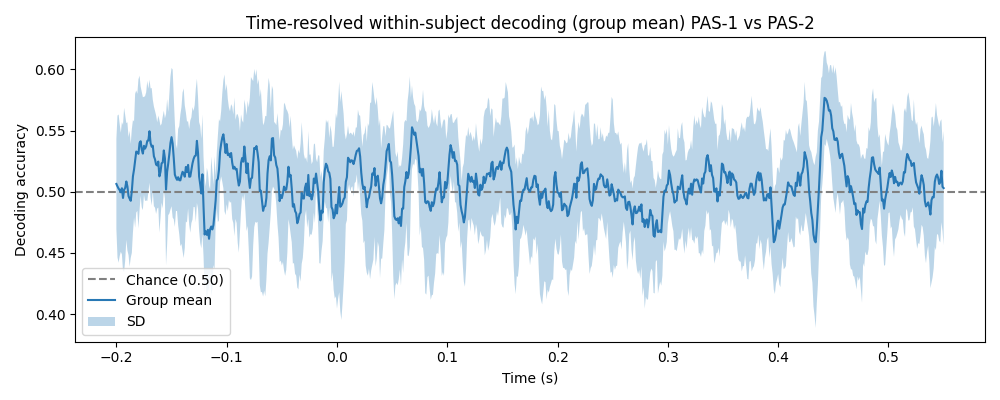

In [82]:
times = epochs_balanced_by_subj["0163"].times

all_scores = np.vstack(list(scores_by_subj.values()))  # subjects × time
mean_scores = all_scores.mean(axis=0)
std_scores = all_scores.std(axis=0)

# Plot
import matplotlib.pyplot as plt

chance = 1.0 / len(np.unique(y))  # binary: 0.5

plt.figure(figsize=(10, 4))
plt.axhline(chance, linestyle="--", color="gray", label=f"Chance ({chance:.2f})")
plt.plot(times, mean_scores, label="Group mean", color = '#2878B5')
plt.fill_between(times, mean_scores - std_scores, mean_scores + std_scores, alpha=0.3, label = "SD")
plt.xlabel("Time (s)")
plt.ylabel("Decoding accuracy")
plt.title("Time-resolved within-subject decoding (group mean) PAS-1 vs PAS-2")
plt.legend()
plt.tight_layout()
plt.show()


In [90]:
import pickle

save_dict = {
    "times": times,
    "scores_by_subj": scores_by_subj,
    "subjects": list(scores_by_subj.keys()),
    "ROIs": ["occipital", "temporal"]
}

with open("decoding_results_1vs2.pkl", "wb") as f:
    pickle.dump(save_dict, f)

print("Decoding results saved to decoding_results_1vs2.pkl")


Decoding results saved to decoding_results_1vs2.pkl


In [100]:
import pickle
import numpy as np

with open("decoding_results_2vs3.pkl", "rb") as f:
    data_2vs3 = pickle.load(f)

times = data_2vs3["times"]                # time vector
scores_by_subj = data_2vs3["scores_by_subj"]  # dict: subj -> n_times array
subjects_2vs3 = data_2vs3["subjects"]          # list of subjects
ROIs_2vs3 = data_2vs3["ROIs"]                  # ["occipital", "temporal"]



In [92]:
S_1vs2 = np.vstack([scores_by_subj_1vs2[subj] for subj in subjects_1vs2])  # shape: n_subjects x n_times


In [101]:
import numpy as np

# Compute group mean across subjects (you already did this)
all_scores = np.vstack(list(scores_by_subj.values()))  # shape: n_subjects × n_timepoints
mean_scores = all_scores.mean(axis=0)                  # shape: n_timepoints

# Find the index of the peak mean
peak_idx = np.argmax(mean_scores)

# Get the peak value
peak_value = mean_scores[peak_idx]

# Get the corresponding time (assuming you have a 'times' array)
peak_time = times[peak_idx]*1000

print(f"Peak mean decoding: {peak_value:.3f} at {peak_time:.1f} ms")


Peak mean decoding: 0.561 at -145.0 ms


In [93]:
from mne.stats import permutation_cluster_1samp_test

# subtract chance (0.5 for binary decoding)
T_obs_1vs2, clusters_1vs2, cluster_p_values_1vs2, H0_1vs2 = permutation_cluster_1samp_test(
    S_1vs2 - 0.5,            # center data at chance
    n_permutations=20000, # number of permutations (can adjust)
    tail=1,             # test above chance
    threshold=None,     # auto-determined threshold
    out_type='mask'     # clusters as boolean masks
)


Using a threshold of 1.894579
stat_fun(H1): min=-2.831039365022241 max=7.846431531086507
Running initial clustering …
Found 22 clusters


  0%|          | Permuting (exact test) : 0/255 [00:00<?,       ?it/s]

In [94]:
significant_clusters = []

for i_c, c in enumerate(clusters_1vs2):
    if cluster_p_values_1vs2[i_c] < 0.05:
        if isinstance(c, tuple):
            cluster_indices = np.arange(*c[0].indices(len(times)))
        else:
            cluster_indices = np.where(c)[0]

        cluster_times_ms = times[cluster_indices] * 1000
        significant_clusters.append({
            "cluster_index": i_c,
            "p_value": cluster_p_values_1vs2[i_c],
            "time_range_ms": (cluster_times_ms[0], cluster_times_ms[-1])
        })

# Print results
for cl in significant_clusters:
    print(f"Cluster {cl['cluster_index']} (p={cl['p_value']:.3f}) "
          f"time range: {cl['time_range_ms'][0]:.1f}–{cl['time_range_ms'][1]:.1f} ms")


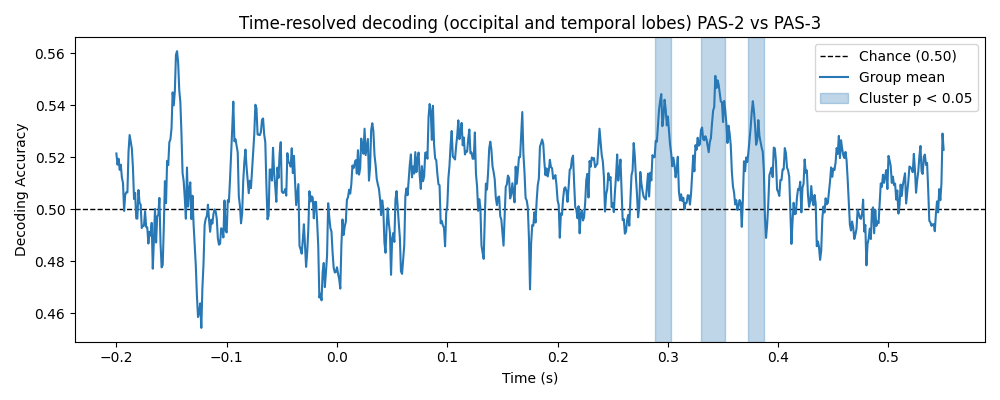

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

all_scores = np.vstack(list(scores_by_subj_2vs3.values()))  # subjects × time
mean_scores = all_scores.mean(axis=0)

chance = 0.5

plt.figure(figsize=(10, 4))

# Plot chance line
plt.axhline(chance, linestyle="--", linewidth=1, color='k', label=f"Chance ({chance:.2f})")

# Plot group mean decoding
plt.plot(times, mean_scores, color='#2878B5', label = "Group mean")

# Shade significant clusters
cluster_label_added = False

for i_c, c in enumerate(clusters_2vs3):
    if cluster_p_values_2vs3[i_c] < 0.05:
        # Convert cluster representation to indices
        if isinstance(c, tuple):  # MNE may return a slice
            cluster_indices = np.arange(*c[0].indices(len(times)))
        else:  # boolean mask
            cluster_indices = np.where(c)[0]

        # Add label only for the first significant cluster
        label = "Cluster p < 0.05" if not cluster_label_added else None
        plt.axvspan(times[cluster_indices[0]], times[cluster_indices[-1]],
                    color='#2878B5', alpha=0.3, label=label)

        cluster_label_added = True  # Don't label subsequent ones
        
plt.xlabel("Time (s)")
plt.ylabel("Decoding Accuracy")
plt.title("Time-resolved decoding (occipital and temporal lobes) PAS-2 vs PAS-3")
plt.legend()
plt.tight_layout()
plt.show()